### Load Libraries

In [244]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import sys
import os

SCRIPT_DIR = os.path.dirname(os.path.abspath('../scripts/scripts/'))
sys.path.append(os.path.dirname(SCRIPT_DIR))

from scripts.constants import PATH_TO_DATA, DATA_FILE_NAME

### Load Dataset

In [245]:
df = pd.read_csv(os.path.join(PATH_TO_DATA, DATA_FILE_NAME), sep='|', names=['sentiment', 'review'], encoding='latin-1')
df.sample(3)

,sentiment,review
6204,1,The characters are so generic and the plot so...
3237,4,Her performance moves between heartbreak and ...
6179,2,These characters become wearisome .


#### About the Dataset

In [246]:
df.shape

(8544, 2)

In [247]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8544 entries, 0 to 8543
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  8544 non-null   int64 
 1   review     8544 non-null   object
dtypes: int64(1), object(1)
memory usage: 133.6+ KB


In [248]:
df.sentiment.unique()

array([4, 5, 3, 2, 1])

In [249]:
df.sentiment.value_counts()

sentiment
4    2322
2    2218
3    1624
5    1288
1    1092
Name: count, dtype: int64

In [250]:
df.sample(3)

,sentiment,review
3991,5,It 's a very valuable film ...
7807,2,The action quickly sinks into by-the-numbers ...
1484,5,One of the very best movies ever made about t...


### Agenda 
The purpose of this notebook is "To compare the performance of different Transformers architectures".

<b>General Approach</b>
1. Research on the different types of Transformers architectures.
2. Conduct analysis on the performance of different Transformers architectures on the given dataset.
3. Report the analysis of performance.


<b>References</b>
1. https://machinelearningmastery.com/the-transformer-model/
2. https://huggingface.co/docs/transformers/index
3. https://pytorch.org/hub/huggingface_pytorch-transformers/

#### Reseach on the different types of Transformers Architectures

There are multiple different types of Transformers Architectures available in the open source market now. With a myriad of options to choose from, one can only decide which one to use based on the performance of the Transformers architecture on the given dataset. In this notebook, I will be exploring the use of Transformers (and their pretrained model weights) to perform sentiment analysis on the given dataset.

I will be using the `pytorch-transformers` package to implement the models. In this package, there are a total of 8 pretrained models to choose from.
- BERT (from Google) released with the paper BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding by Jacob Devlin, Ming-Wei Chang, Kenton Lee and Kristina Toutanova.
- GPT (from OpenAI) released with the paper Improving Language Understanding by Generative Pre-Training by Alec Radford, Karthik Narasimhan, Tim Salimans and Ilya Sutskever.
- GPT-2 (from OpenAI) released with the paper Language Models are Unsupervised Multitask Learners by Alec Radford, Jeffrey Wu, Rewon Child, David Luan, Dario Amodei** and Ilya Sutskever**.
- Transformer-XL (from Google/CMU) released with the paper Transformer-XL: Attentive Language Models Beyond a Fixed-Length Context by Zihang Dai, Zhilin Yang, Yiming Yang, Jaime Carbonell, Quoc V. Le, Ruslan Salakhutdinov.
- XLNet (from Google/CMU) released with the paper ​XLNet: Generalized Autoregressive Pretraining for Language Understanding by Zhilin Yang, Zihang Dai, Yiming Yang, Jaime Carbonell, Ruslan Salakhutdinov, Quoc V. Le.
- XLM (from Facebook) released together with the paper Cross-lingual Language Model Pretraining by Guillaume Lample and Alexis Conneau.
- RoBERTa (from Facebook), released together with the paper a Robustly Optimized BERT Pretraining Approach by Yinhan Liu, Myle Ott, Naman Goyal, Jingfei Du, Mandar Joshi, Danqi Chen, Omer Levy, Mike Lewis, Luke Zettlemoyer, Veselin Stoyanov.
- DistilBERT (from HuggingFace), released together with the blogpost Smaller, faster, cheaper, lighter: Introducing DistilBERT, a distilled version of BERT by Victor Sanh, Lysandre Debut and Thomas Wolf.

##### Implementing BERT for Sentiment Analysis
Reference: https://github.com/bentrevett/pytorch-sentiment-analysis/blob/master/6%20-%20Transformers%20for%20Sentiment%20Analysis.ipynb

In [251]:
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import BertTokenizer, BertModel
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from string import punctuation
import time

device = "cuda" if torch.cuda.is_available() else "cpu"

In [252]:
# Initialize tokenizer for BERT Model 
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# This tokenization step is critical during the pre-training phase of BERT, allowing the model to effectively learn the relationships between words or sub-words.

In [253]:
# Check maximum length of sequences
max_input_length = tokenizer.max_model_input_sizes['bert-base-uncased']
print(max_input_length)

# Model cannot perform well if the number of tokens trained on < input number of tokens
# Therefore, a small experiment to determine if the said model tokenizer can perform decently well is to check the max number of tokens in the given dataset

512


<Axes: xlabel='n_tokens'>

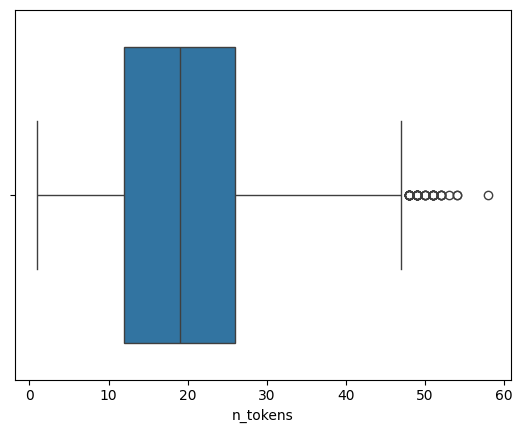

In [254]:
# Determine the maximum number of possible tokens
df_copy = df.copy()

# Define pre-processing function (remove numbers and punctuations)
def preprocess_text(text:str) -> str:
    # Case text to lower case
    text_lowercase = text.lower()
    
    # Strip whitespaces
    text_no_ws = " ".join([x for x in text_lowercase.split(" ") if x != " "])
    
    # Remove punctuation
    text_no_punc = ''.join([x for x in text_no_ws if x not in punctuation])
    
    # Remove numbers
    text_no_num = ''.join([x for x in text_no_punc if x.isalpha() or x == " "])
    
    return text_no_num

df_copy['review_cleaned'] = df_copy['review'].apply(preprocess_text)


# Count number of tokens
df_copy['n_tokens'] = df_copy['review_cleaned'].apply(lambda x: len(tokenizer.tokenize(x)))

# Display counts for tokens
sns.boxplot(data=df_copy, x='n_tokens')

In [255]:
n_tokens_max, n_tokens_min = df_copy['n_tokens'].max(), df_copy['n_tokens'].min()
print(f'Max: {n_tokens_max}\nMin: {n_tokens_min}')

Max: 58
Min: 1


Since `n_tokens_max` is less than 512, the model will perform decently.

In [256]:
# Create tokens 
df_copy['tokens'] = df_copy['review_cleaned'].apply(lambda x: tokenizer.tokenize(x))

In [257]:
# Slice dataframe in features and labels
X = df_copy[['review_cleaned']]
y = df_copy[['sentiment']]

In [258]:
# Prepare the Dataset
TEST_SIZE = 0.05
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE)

In [259]:
# Display Shapes
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape, end='\n\n')

print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (8116, 1)
Shape of y_train: (8116, 1)

Shape of X_test: (428, 1)
Shape of y_test: (428, 1)


In [235]:
# Create Iterables
train_iter = pd.concat([X_train, y_train], axis=1).to_dict(orient='records')
test_iter = pd.concat([X_test, y_test], axis=1).to_dict(orient='records')

# Define Batch Size
BATCH_SIZE = 64

# Create DataLoaders
train_dataloader = DataLoader(train_iter, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_iter, batch_size=BATCH_SIZE, shuffle=True)

In [236]:
# Define BERT Model
bert = BertModel.from_pretrained('bert-base-uncased')

In [237]:
class BERTGRUSentiment(nn.Module):
    def __init__(self,
                 bert,
                 hidden_dim,
                 output_dim,
                 n_layers,
                 bidirectional,
                 dropout):
        
        super().__init__()
        
        self.bert = bert
        
        embedding_dim = bert.config.to_dict()['hidden_size']
        
        self.rnn = nn.GRU(embedding_dim,
                          hidden_dim,
                          num_layers = n_layers,
                          bidirectional = bidirectional,
                          batch_first = True,
                          dropout = 0 if n_layers < 2 else dropout)
        
        self.out = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
        
        #text = [batch size, sent len]
                
        with torch.no_grad():
            embedded = self.bert(text)[0]
                
        #embedded = [batch size, sent len, emb dim]
        
        _, hidden = self.rnn(embedded)
        
        #hidden = [n layers * n directions, batch size, emb dim]
        
        if self.rnn.bidirectional:
            hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
        else:
            hidden = self.dropout(hidden[-1,:,:])
                
        #hidden = [batch size, hid dim]
        
        output = self.out(hidden)
        
        #output = [batch size, out dim]
        
        return output

In [219]:
# Define Hyperparameters for BERT
HIDDEN_DIM = 256
OUTPUT_DIM = 1
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.25

model = BERTGRUSentiment(bert,
                         HIDDEN_DIM,
                         OUTPUT_DIM,
                         N_LAYERS,
                         BIDIRECTIONAL,
                         DROPOUT)

In [220]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 112,241,409 trainable parameters


In [221]:
# Freeze Params for BERT Model to prevent re-training
for name, param in model.named_parameters():                
    if name.startswith('bert'):
        param.requires_grad = False

In [222]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 2,759,169 trainable parameters


In [223]:
# Display layers that require training
for name, param in model.named_parameters():                
    if param.requires_grad:
        print(name)

rnn.weight_ih_l0
rnn.weight_hh_l0
rnn.bias_ih_l0
rnn.bias_hh_l0
rnn.weight_ih_l0_reverse
rnn.weight_hh_l0_reverse
rnn.bias_ih_l0_reverse
rnn.bias_hh_l0_reverse
rnn.weight_ih_l1
rnn.weight_hh_l1
rnn.bias_ih_l1
rnn.bias_hh_l1
rnn.weight_ih_l1_reverse
rnn.weight_hh_l1_reverse
rnn.bias_ih_l1_reverse
rnn.bias_hh_l1_reverse
out.weight
out.bias


In [224]:
def accuracy(preds, y):
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

In [225]:
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

In [226]:
def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        
        optimizer.zero_grad()

        predictions = model(batch.get("review_cleaned")).squeeze(1)
        
        loss = criterion(predictions, batch.get("sentiment"))
        
        acc = accuracy(predictions, batch.get("sentiment"))
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [227]:
def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:

            predictions = model(batch.get("review_cleaned")).squeeze(1)
            
            loss = criterion(predictions, batch.get("sentiment"))
            
            acc = accuracy(predictions, batch.get("sentiment"))

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [228]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [229]:
N_EPOCHS = 5

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss, train_acc = train(model, train_dataloader, optimizer, criterion)
    test_loss, test_acc = evaluate(model, test_dataloader, criterion)
        
    end_time = time.time()
        
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        
    if test_loss < best_test_loss:
        best_test_loss = test_loss
        torch.save(model.state_dict(), 'tut6-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {test_loss:.3f} |  Val. Acc: {test_acc*100:.2f}%')

RuntimeError: each element in list of batch should be of equal size

#### Conduct analysis on the different types of Transformers Architectures

#### Report the analysis of performance